In [305]:
import numpy as np

with np.load('cifar4-train.npz', allow_pickle=False) as npz_file:
    df = dict(npz_file.items())
X = df['pixels']
y = df['labels']
X.dtype, y.dtype

(dtype('uint8'), dtype('int64'))

In [306]:
X = X.astype(np.float32)
X.dtype

dtype('float32')

In [307]:
# Rescale pixel values between -0.5 and 0.5
X = (X - 128) / 255

In [308]:
from sklearn.model_selection import train_test_split
X_tr,X_te,y_tr,y_te = train_test_split(X.reshape(-1,32,32,3),y,train_size=4000,test_size=1000,random_state=0,stratify = y)
X_tr_tr,X_tr_valid,y_tr_tr,y_tr_valid = train_test_split(X_tr,y_tr,train_size=3200,test_size=800,random_state=0)

In [309]:
# Redefine graph
graph = tf.Graph()

with graph.as_default():
    # Placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 32, 32, 3])
    y = tf.placeholder(dtype=tf.int64, shape=[None])

    # Convolutional layer
    conv = tf.layers.conv2d(
        X, 
        filters=64, 
        kernel_size=(5, 5), 
        strides=(2, 2), 
        padding='SAME', 
        activation=tf.nn.relu,
        kernel_initializer=tf.truncated_normal_initializer(
            stddev=0.01, seed=0), 
        name='conv' 
    )

print(conv.shape) 

(?, 16, 16, 64)


In [310]:
with graph.as_default():
    # Max pooling layer
    pool = tf.layers.max_pooling2d(
        conv, # Convolution output
        pool_size=(2, 2), 
        strides=(2, 2), 
        padding='SAME' 
    )

print(pool.shape)

(?, 8, 8, 64)


In [311]:
with graph.as_default():
    # Convolutional layer
    conv2 = tf.layers.conv2d(
        pool, 
        filters=128, 
        kernel_size=(3, 3),
        strides=(1, 1), 
        padding='SAME', 
        activation=tf.nn.relu, 
        kernel_initializer=tf.truncated_normal_initializer(
            stddev=0.01, seed=0), 
        name='conv3', 
    )
print(conv2.shape)

(?, 8, 8, 128)


In [312]:
with graph.as_default():
    pool2 = tf.layers.max_pooling2d(
        conv2, pool_size=(2, 2), strides=(2, 2), padding='SAME')
print(pool2.shape)

(?, 4, 4, 128)


In [314]:
with graph.as_default():
    training = tf.placeholder(dtype=tf.bool)
    pool2 = tf.layers.dropout(pool2, rate=0.5, seed=0, training=training)

In [316]:
with graph.as_default():
    # Flatten output
    flat_output = tf.contrib.layers.flatten(pool2)

print(flat_output.shape)

(?, 2048)


In [317]:
with graph.as_default():
    # dense layer No.1
    dense_1 = tf.layers.dense(
        flat_output, 256, 
        activation=None, # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='dense_1'
    )
print(dense_1.shape)

(?, 256)


In [318]:
with graph.as_default():
    # dense layer No.1
    logits = tf.layers.dense(
        dense_1, 4, 
        activation=None, # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='dense'
    )
print(logits.shape)

(?, 4)


In [319]:
with graph.as_default():
    # Mean cross-entropy
    mean_ce = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y, logits=logits))

    # Adam optimizer
    lr = tf.placeholder(dtype=tf.float32)
    gd = tf.train.AdamOptimizer(learning_rate=lr)

    # Minimize cross-entropy
    train_op = gd.minimize(mean_ce)

    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int64)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

In [320]:
with graph.as_default():
    # Kernel weights of the 1st conv. layer
    with tf.variable_scope('conv', reuse=True):
        conv_kernels = tf.get_variable('kernel')

print(conv_kernels.shape) 

(5, 5, 3, 64)


In [321]:
# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y)) # 1,2,...,n
    np.random.shuffle(shuffled_idx)

    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

In [322]:
# Validation accuracy
valid_acc_values = []

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Set seed
    np.random.seed(0)

    # Train several epochs
    for epoch in range(50):
        # Accuracy values (train) after each batch
        batch_acc = []

        for X_batch, y_batch in get_batches(X_tr_tr, y_tr_tr, 64):
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy], feed_dict={
                X: X_batch,
                y: y_batch,
                training: True,
                lr: 0.001 # Learning rate
            })

            # Save accuracy (current batch)
            batch_acc.append(acc_value)

        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={
            X: X_tr_valid,
            y: y_tr_valid,
            training: False
        })
        valid_acc_values.append(valid_acc)

        # Print progress
        print('Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(
            epoch+1, valid_acc, np.mean(batch_acc)
        ))

    # Get 1st conv. layer kernels
    kernels = conv_kernels.eval()

Epoch 1 - valid: 0.524 train: 0.457 (mean)
Epoch 2 - valid: 0.569 train: 0.556 (mean)
Epoch 3 - valid: 0.637 train: 0.603 (mean)
Epoch 4 - valid: 0.674 train: 0.646 (mean)
Epoch 5 - valid: 0.679 train: 0.688 (mean)
Epoch 6 - valid: 0.680 train: 0.723 (mean)
Epoch 7 - valid: 0.725 train: 0.733 (mean)
Epoch 8 - valid: 0.736 train: 0.765 (mean)
Epoch 9 - valid: 0.726 train: 0.788 (mean)
Epoch 10 - valid: 0.736 train: 0.799 (mean)
Epoch 11 - valid: 0.765 train: 0.795 (mean)
Epoch 12 - valid: 0.748 train: 0.824 (mean)
Epoch 13 - valid: 0.755 train: 0.833 (mean)
Epoch 14 - valid: 0.750 train: 0.842 (mean)
Epoch 15 - valid: 0.755 train: 0.860 (mean)
Epoch 16 - valid: 0.760 train: 0.858 (mean)
Epoch 17 - valid: 0.772 train: 0.872 (mean)
Epoch 18 - valid: 0.765 train: 0.881 (mean)
Epoch 19 - valid: 0.755 train: 0.886 (mean)
Epoch 20 - valid: 0.766 train: 0.888 (mean)
Epoch 21 - valid: 0.767 train: 0.896 (mean)
Epoch 22 - valid: 0.760 train: 0.895 (mean)
Epoch 23 - valid: 0.772 train: 0.897 (mea

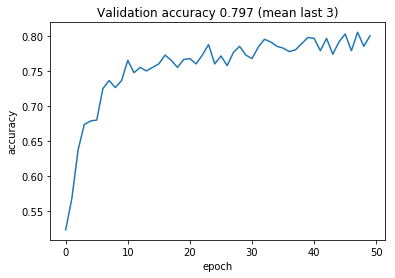

In [323]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot accuracy values
plt.plot(valid_acc_values)
plt.title('Validation accuracy {:.3f} (mean last 3)'.format(
    np.mean(valid_acc_values[-3:]) # last three values
))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

Evaluate test set

In [326]:
# Validation accuracy
test_acc_values = []

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Set seed
    np.random.seed(0)

    # Train several epochs
    for epoch in range(50):
        # Accuracy values (train) after each batch
        batch_acc = []

        for X_batch, y_batch in get_batches(X_tr, y_tr, 64):
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy], feed_dict={
                X: X_batch,
                y: y_batch,
                training: True,
                lr: 0.001 # Learning rate
            })

            # Save accuracy (current batch)
            batch_acc.append(acc_value)

        # Evaluate validation accuracy
        test_acc = sess.run(accuracy, feed_dict={
            X: X_te,
            y: y_te,
            training: False
        })
        test_acc_values.append(test_acc)

        # Print progress
        print('Epoch {} - test: {:.3f} train: {:.3f} (mean)'.format(
            epoch+1, test_acc, np.mean(batch_acc)
        ))

    # Get 1st conv. layer kernels
    kernels = conv_kernels.eval()

Epoch 1 - test: 0.580 train: 0.489 (mean)
Epoch 2 - test: 0.632 train: 0.574 (mean)
Epoch 3 - test: 0.681 train: 0.637 (mean)
Epoch 4 - test: 0.702 train: 0.667 (mean)
Epoch 5 - test: 0.726 train: 0.723 (mean)
Epoch 6 - test: 0.739 train: 0.731 (mean)
Epoch 7 - test: 0.743 train: 0.765 (mean)
Epoch 8 - test: 0.763 train: 0.768 (mean)
Epoch 9 - test: 0.772 train: 0.792 (mean)
Epoch 10 - test: 0.753 train: 0.803 (mean)
Epoch 11 - test: 0.755 train: 0.826 (mean)
Epoch 12 - test: 0.769 train: 0.825 (mean)
Epoch 13 - test: 0.777 train: 0.842 (mean)
Epoch 14 - test: 0.772 train: 0.859 (mean)
Epoch 15 - test: 0.783 train: 0.862 (mean)
Epoch 16 - test: 0.779 train: 0.859 (mean)
Epoch 17 - test: 0.780 train: 0.880 (mean)
Epoch 18 - test: 0.782 train: 0.883 (mean)
Epoch 19 - test: 0.793 train: 0.893 (mean)
Epoch 20 - test: 0.793 train: 0.899 (mean)
Epoch 21 - test: 0.792 train: 0.900 (mean)
Epoch 22 - test: 0.792 train: 0.907 (mean)
Epoch 23 - test: 0.795 train: 0.914 (mean)
Epoch 24 - test: 0.8

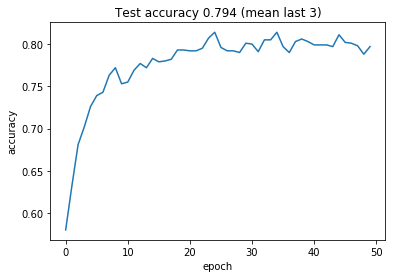

In [327]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot accuracy values
plt.plot(test_acc_values)
plt.title('Test accuracy {:.3f} (mean last 3)'.format(
    np.mean(test_acc_values[-3:]) # last three values
))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

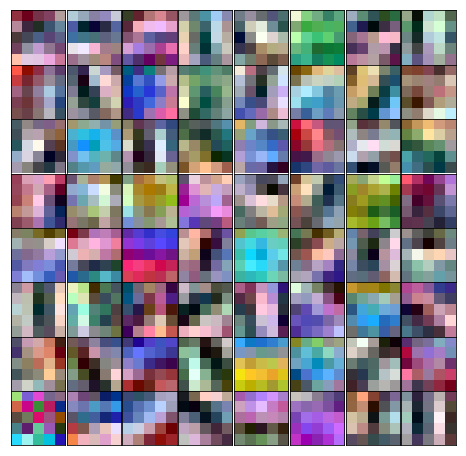

In [328]:
# Create a grid of subplots
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(8, 8))

# Remove gaps between suplots
plt.subplots_adjust(wspace=0, hspace=0)

# Plot the 64 kernels from the first convolutional layer
for i, axis in enumerate(axes.flatten()):
    # Get i-th kernel (shape: 5x5x3)
    kernel = kernels[:, :, :, i].copy()
    
    # Rescale values between 0 and 1
    kernel -= kernel.min() # Rescale between 0 and max
    kernel /= kernel.max() # Rescale between 0 and 1
    
    # Plot kernel with imshow()
    axis.imshow(kernel)
    axis.get_xaxis().set_visible(False) # disable x-axis
    axis.get_yaxis().set_visible(False) # disable y-axis
    
plt.show()